## Multi-label prediction with Planet Amazon dataset

### Learning:
- `data_block` has `.databunch()` which creates in one go both
     1. "train_dl" `DataLoader` and "valid_dl" `DataLoader`, and
     2. a `DataBunch` object that takes the above two `DataLoader` objects
- `metrics` specified in the `learner` has nothing to do with how the learner is trained. `metrics` is only something that we print during training.
- Regarding the use of `slice` in setting the learning rate, assuming the learner has 3 layer groups: 
    - `learn.lr_range(slice(1e-5, 1e-3))` results in `(array([1.e-05, 1.e-04, 1.e-03])` The low end of the learning rate needs to be at least 10 times smaller than the high end of the learning rate.
    - `learn.lr_range(slice(1e-3))` results in `array([0.0001, 0.0001, 0.001]))`
- What we pass to `fit_one_cycle` is always the maximum learning rate of the low-high-low learning rate schedule.
- When training a frozen network, where the learning rate curve is V shaped, set the high end of the learning rate as the learning rate at the steeppest point of the loss slope (this is Jeremy Howard's way. Or choose 10% of [the learning rate of the lowest loss], which is Sylvian's way).
- When training a unfrozen network, where the learning rate curve is RELU shaped, assume that the learning rate is specified as `slice(low_end, high_end)`, set the low end of the learning rate as 10% of the learning rate at the right most point before loss surges on the loss slope, and the high end of the learning rate as 10% or 20% of the frozen network learning rate.
- There is a trick to first train the model on smaller images (128 x 128 in this case), and then keep training the model on the original images (256 x 256 in this case) as a "new" dataset.
- Make the batch size smaller if GPU memory size is a problem.
- Use `to_fp16` if GPU memory size is a problem, e.g. `unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()`
- From https://sgugger.github.io/the-1cycle-policy.html

<img src="images/best_learning_rate_other_parameters.png" width=800 height=800 >

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
! {sys.executable} -m pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 261kB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 498kB/s ta 0:00:011
  Stored in directory: /Users/p787144/Library/Caches/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Stored in directory: /Users/p787144/Library/Caches/pip/wheels/11/94/81/312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f
Successfully built kaggle python-slugify


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [4]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [5]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/Users/p787144/.fastai/data/planet')

In [13]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

#### At the end the way that will work is to download the dataset manually from Kaggle's website to the laptop, unzip it, and start from there.

In [20]:
import py7zr

archive = py7zr.SevenZipFile(path/'train-jpg.tar.7z', mode='r')
archive.extractall(path=path/"train-jpg")
archive.close()

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [ ]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [ ]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [5]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

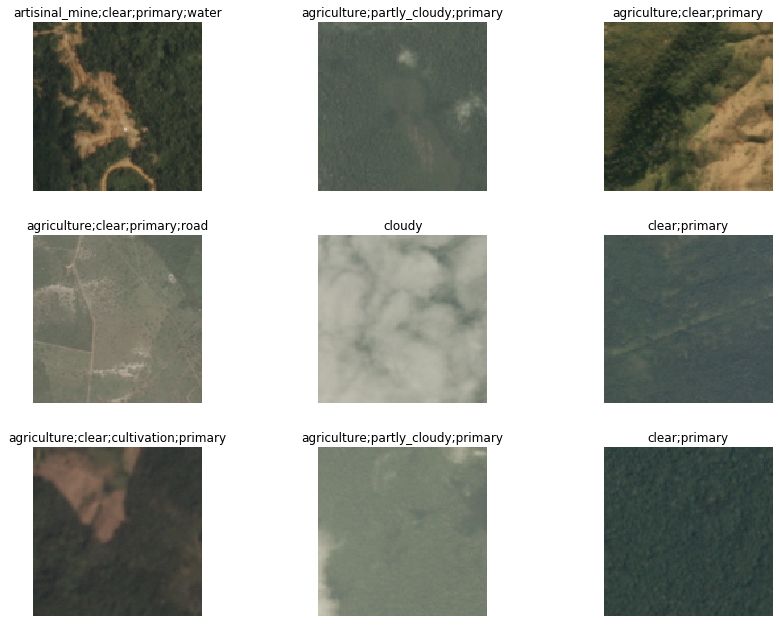

In [9]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [12]:
#arch = models.resnet50
arch = models.resnet18

Because it is a multilabel problem, as long as a class passes a threshold, the image will get that class as a label.

`partial` is about always assigning a constant to a function. `partial` returns a modified version of the original function.

In [13]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


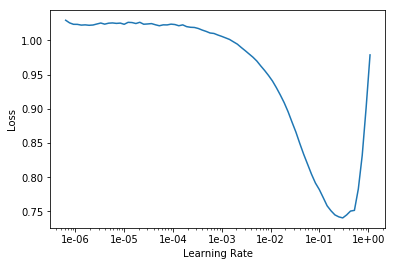

In [15]:
learn.recorder.plot()

Then we can fit the head of our network.

In [16]:
lr = 0.01

In [17]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.147571,0.125619,0.938488,0.891177,24:35
1,0.120455,0.105799,0.947869,0.908412,24:04
2,0.109060,0.097421,0.948945,0.914500,24:01
3,0.104114,0.093998,0.949860,0.918506,23:52
4,0.100414,0.093188,0.950805,0.918578,23:52


In [18]:
# learn.save('stage-1-rn50')
learn.save('stage-1-rn18')

...And fine-tune the whole model:

In [19]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


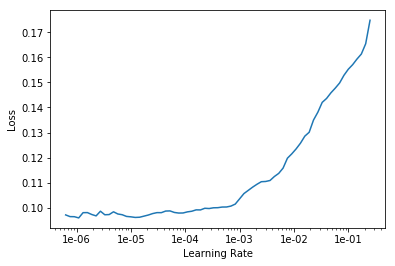

In [20]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.101952,0.095165,0.946518,0.915356,34:41
1,0.101553,0.092360,0.955383,0.920519,35:13
2,0.094593,0.087946,0.953581,0.924573,34:27
3,0.089985,0.086004,0.956371,0.924729,34:25
4,0.084564,0.085072,0.957047,0.926970,34:22


In [29]:
# learn.save('stage-2-rn50')
learn.save('stage-2-rn18')

## We have trained our model on 128 x 128 images, now keep training the model on the original 256 x 256 images as a "new" dataset.

In [30]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [31]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


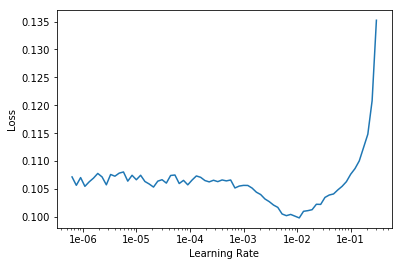

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
lr=1e-2/2

In [34]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.090833,0.088233,0.954358,0.922769,1:35:00
1,0.090452,0.086273,0.955840,0.924300,1:34:33
2,0.088853,0.085120,0.958834,0.926300,1:33:44
3,0.083892,0.083568,0.958580,0.927624,1:36:18
4,0.084009,0.083360,0.956785,0.927278,1:35:14


In [35]:
learn.save('stage-1-256-rn18')

In [36]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088620,0.085632,0.954554,0.925141,2:12:29
1,0.088090,0.085267,0.955848,0.926043,2:08:21
2,0.084948,0.083306,0.957047,0.928441,2:07:02
3,0.084381,0.082166,0.959794,0.930112,2:06:22
4,0.079444,0.081766,0.959394,0.929475,2:06:05


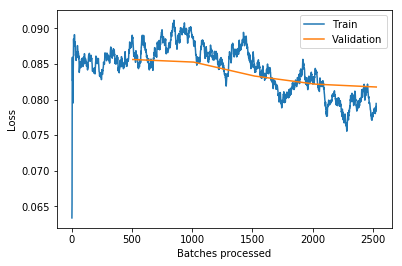

In [38]:
learn.recorder.plot_losses()

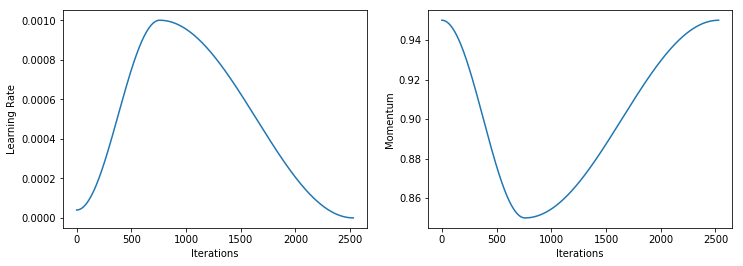

In [41]:
learn.recorder.plot_lr(show_moms=True)

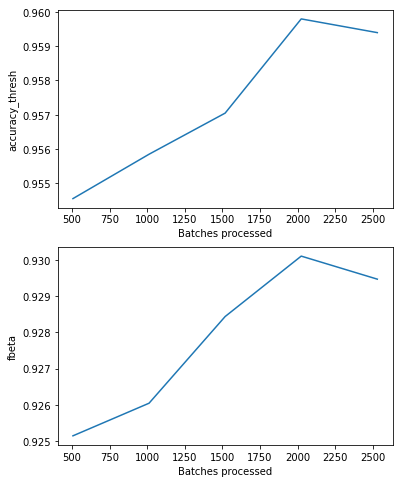

In [42]:
learn.recorder.plot_metrics()

In [43]:
learn.save('stage-2-256-rn18')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [44]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)